# **Fine-Tuning Deep Neural Network From Scratch in Python**

*By Cristian Leo*

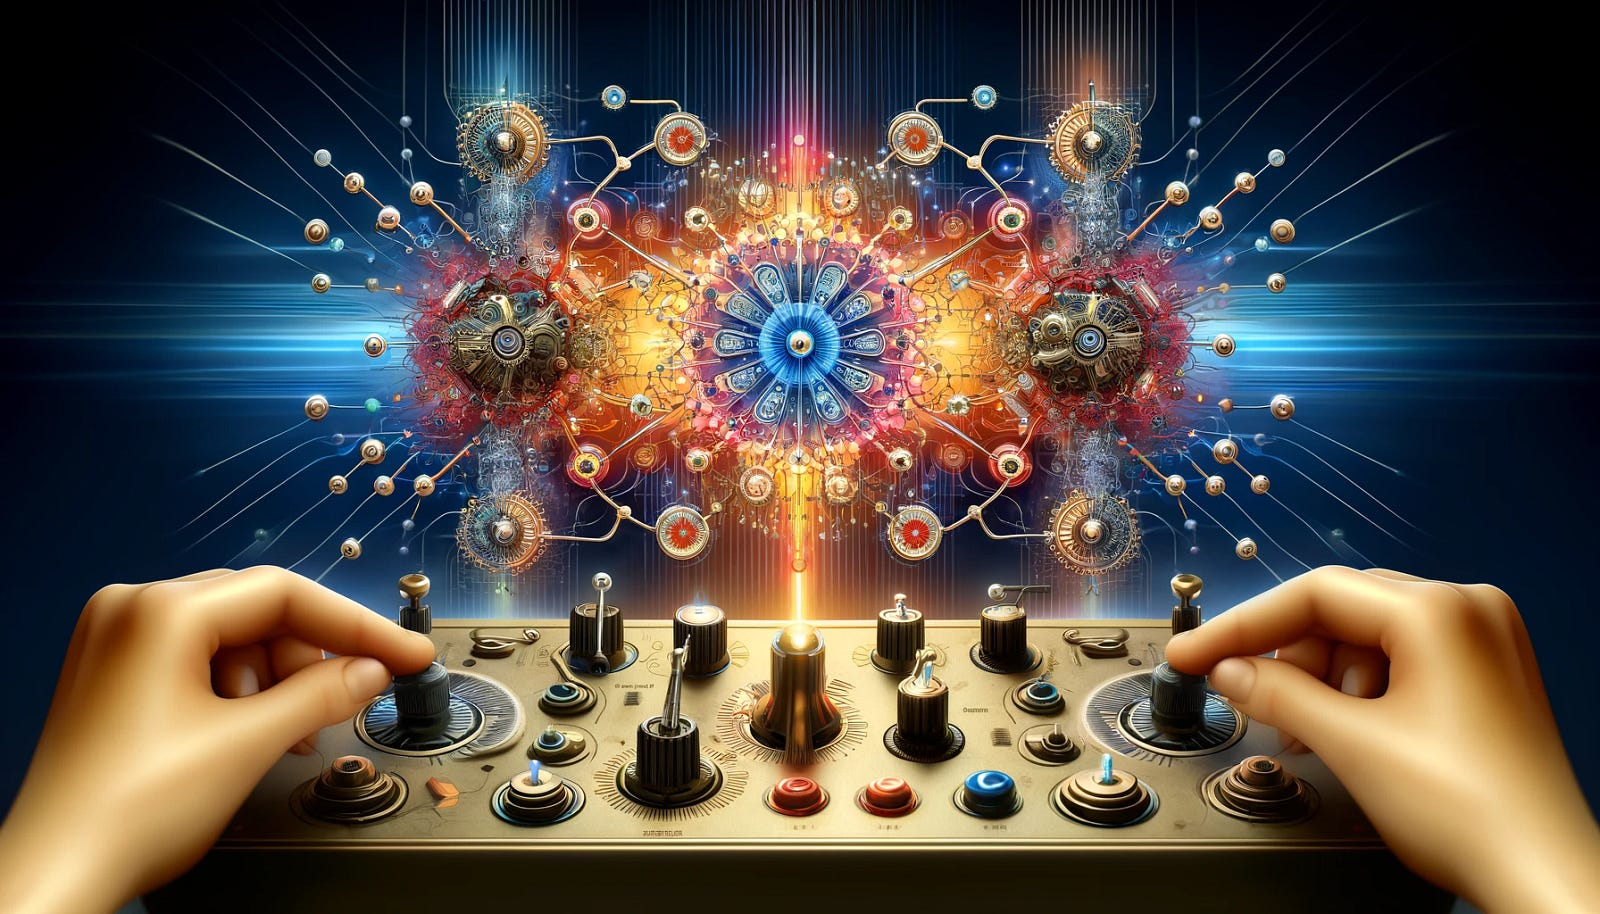

## **Libraries**

In [53]:
import numpy as np # linear algebra

import matplotlib.pyplot as plt # this is used for the plot the graph

from sklearn.datasets import load_digits # this is used for import the dataset
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.preprocessing import MinMaxScaler # for normalization
from sklearn.preprocessing import OneHotEncoder # for one hot encoding

import optuna # for hyperparameter tuning

import logging
# Set up the logger
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

import warnings # this is used for ignoring the warnings
warnings.filterwarnings("ignore")

## **Neural Network Class**

In [54]:
class NeuralNetwork:
    """
    A feedforward neural network with a few optimization techniques.

    Parameters:
    -----------
    layers: list of int
        The number of neurons in each layer including the input and output layer
    loss_func: str
        The loss function to use. Options are 'mse' for mean squared error, 'log_loss' for logistic loss, and 'categorical_crossentropy' for categorical crossentropy.
    dropout_rate: float
        The dropout rate for dropout regularization. Must be between 0 and 1.
    grad_clip: float
        The gradient clipping threshold.
    """
    def __init__(self, 
                 layers,
                 init_method='glorot_uniform', # 'zeros', 'random', 'glorot_uniform', 'glorot_normal', 'he_uniform', 'he_normal'
                 loss_func='mse', 
                 dropout_rate=0.5, 
                 clip_type='value',
                 grad_clip=5.0
                 ):
        self.layers = []
        self.loss_func = loss_func
        self.dropout_rate = dropout_rate
        self.clip_type = clip_type
        self.grad_clip = grad_clip
        self.init_method = init_method

        # Initialize layers
        for i in range(len(layers) - 1):
            if self.init_method == 'zeros':
                weights = np.zeros((layers[i], layers[i + 1]))
            elif self.init_method == 'random':
                weights = np.random.randn(layers[i], layers[i + 1])
            elif self.init_method == 'glorot_uniform':
                weights = self.glorot_uniform(layers[i], layers[i + 1])
            elif self.init_method == 'glorot_normal':
                weights = self.glorot_normal(layers[i], layers[i + 1])
            elif self.init_method == 'he_uniform':
                weights = self.he_uniform(layers[i], layers[i + 1])
            elif self.init_method == 'he_normal':
                weights = self.he_normal(layers[i], layers[i + 1])

            else:
                raise ValueError(f'Unknown initialization method {self.init_method}')

            self.layers.append({
                'weights': weights,
                'biases': np.zeros((1, layers[i + 1]))
            })

        # track loss
        self.train_loss = []
        self.test_loss = []

    def __str__(self):
        """
        Print the Neural Network architecture.
        """
        structure = f"NN Layout:\nInput Layer: {len(self.layers[0]['weights'])} neurons"
        for i, layer in enumerate(self.layers[1:]):
            if i==len(self.layers):
                f"\nOutput Layer: {len(self.layers[-1]['weights'])} neurons\nLoss Function: {self.loss_func}"
            else:
                structure += f"s\nHidden Layer {i+1}: {len(layer['weights'])} neurons"
        return structure
        

    def glorot_uniform(self, fan_in, fan_out):
        """
        Glorot Uniform initialization (also known as Xavier Uniform initialization).

        Parameters:
        -----------
        fan_in: int
            The number of input units in the weight tensor
        fan_out: int
            The number of output units in the weight tensor

        Returns:
        --------
        numpy array
            The initialized weights
        """
        limit = np.sqrt(6 / (fan_in + fan_out))
        return np.random.uniform(-limit, limit, (fan_in, fan_out))

    def he_uniform(self, fan_in, fan_out):
        """
        He initialization.

        Parameters:
        -----------
        fan_in: int
            The number of input units in the weight tensor
        fan_out: int
            The number of output units in the weight tensor
        
        Returns:
        --------
        numpy array
            The initialized weights
        """
        limit = np.sqrt(2 / fan_in)
        return np.random.uniform(-limit, limit, (fan_in, fan_out))
    
    def glorot_normal(self, fan_in, fan_out):
        """
        Glorot Normal initialization (also known as Xavier Normal initialization).
        
        Parameters:
        -----------
        fan_in: int
            The number of input units in the weight tensor
        fan_out: int
            The number of output units in the weight tensor
        
        Returns:
        --------
        numpy array
            The initialized weights
        """
        stddev = np.sqrt(2. / (fan_in + fan_out))
        return np.random.normal(0., stddev, size=(fan_in, fan_out))

    def he_normal(self, fan_in, fan_out):
        """
        He Normal initialization.

        Parameters:
        -----------
        fan_in: int
            The number of input units in the weight tensor
        fan_out: int
            The number of output units in the weight tensor

        Returns:
        --------
        numpy array
            The initialized weights
        """
        stddev = np.sqrt(2. / fan_in)
        return np.random.normal(0., stddev, size=(fan_in, fan_out))


    def forward(self, X, is_training=True):
        """
        Perform forward propagation.
        
        Parameters:
        -----------
        X: numpy array
            The input data
        is_training: bool
            Whether the forward pass is for training or testing/prediction
        
        Returns:
        --------
        numpy array
            The predicted output
        """
        self.a = [X]
        for i, layer in enumerate(self.layers):
            z = np.dot(self.a[-1], layer['weights']) + layer['biases']
            a = self.sigmoid(z)
            if is_training and i < len(self.layers) - 1:  # apply dropout to all layers except the output layer
                dropout_mask = np.random.rand(*a.shape) > self.dropout_rate
                a *= dropout_mask
            self.a.append(a)
        return self.a[-1]

    def backward(self, X, y, learning_rate):
        """
        Perform backpropagation.

        Parameters:
        -----------
        X: numpy array
            The input data
        y: numpy array
            The target output
        learning_rate: float
            The learning rate
        """
        m = X.shape[0]
        self.dz = [self.a[-1] - y]
        self.gradient_norms = []  # List to store the gradient norms

        for i in reversed(range(len(self.layers) - 1)):
            self.dz.append(np.dot(self.dz[-1], self.layers[i + 1]['weights'].T) * self.sigmoid_derivative(self.a[i + 1]))
            self.gradient_norms.append(np.linalg.norm(self.layers[i + 1]['weights']))  # Compute and store the gradient norm

        self.dz = self.dz[::-1]
        self.gradient_norms = self.gradient_norms[::-1]  # Reverse the list to match the order of the layers

        for i in range(len(self.layers)):
            grads_w = np.dot(self.a[i].T, self.dz[i]) / m
            grads_b = np.sum(self.dz[i], axis=0, keepdims=True) / m

            # gradient clipping
            if self.clip_type == 'value':
                grads_w = np.clip(grads_w, -self.grad_clip, self.grad_clip)
                grads_b = np.clip(grads_b, -self.grad_clip, self.grad_clip)
            elif self.clip_type == 'norm':
                grads_w = self.clip_by_norm(grads_w, self.grad_clip)
                grads_b = self.clip_by_norm(grads_b, self.grad_clip)

            self.layers[i]['weights'] -= learning_rate * grads_w
            self.layers[i]['biases'] -= learning_rate * grads_b

    def clip_by_norm(self, grads, clip_norm):
        """
        Clip gradients by norm.

        Parameters:
        -----------
        grads: numpy array
            The gradients
        clip_norm: float
            The threshold for clipping
        
        Returns:
        --------
        numpy array
            The clipped gradients
        """
        l2_norm = np.linalg.norm(grads)
        if l2_norm > clip_norm:
            grads = grads / l2_norm * clip_norm
        return grads
    
    def sigmoid(self, x):
        """
        Sigmoid activation function.
        
        Parameters:
        -----------
        x: numpy array
            The input data
        
        Returns:
        --------
        numpy array
            The output of the sigmoid function
        """
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_derivative(self, x):
        """
        Derivative of the sigmoid activation function.

        Parameters:
        -----------
        x: numpy array
            The input data
        
        Returns:
        --------
        numpy array
            The output of the derivative of the sigmoid function
        """
        return x * (1 - x)

## **Trainer Class**

In [55]:
class Trainer:
    """
    A class to train a neural network.

    Parameters:
    -----------
    model: NeuralNetwork
        The neural network model to train
    loss_func: str
        The loss function to use. Options are 'mse' for mean squared error, 'log_loss' for logistic loss, and 'categorical_crossentropy' for categorical crossentropy.
    """
    def __init__(self, model, loss_func='mse'):
        self.model = model
        self.loss_func = loss_func
        self.train_loss = []
        self.val_loss = []

    def calculate_loss(self, y_true, y_pred):
        """
        Calculate the loss.

        Parameters:
        -----------
        y_true: numpy array
            The true output
        y_pred: numpy array
            The predicted output
        
        Returns:
        --------
        float
            The loss
        """
        if self.loss_func == 'mse':
            return np.mean((y_pred - y_true)**2)
        elif self.loss_func == 'log_loss':
            return -np.mean(y_true*np.log(y_pred) + (1-y_true)*np.log(1-y_pred))
        elif self.loss_func == 'categorical_crossentropy':
            return -np.mean(y_true*np.log(y_pred))
        else:
            raise ValueError('Invalid loss function')

    def train(self, X_train, y_train, X_val, y_val, epochs, learning_rate, early_stopping=True, patience=10):
        """
        Train the neural network.

        Parameters:
        -----------
        X_train: numpy array
            The training input data
        y_train: numpy array
            The training target output
        X_val: numpy array
            The test input data
        y_val: numpy array
            The test target output
        epochs: int
            The number of epochs to train the model
        learning_rate: float
            The learning rate
        early_stopping: bool
            Whether to stop training early if the test loss doesn't improve for a number of epochs
        patience: int
            The number of epochs to wait for an improvement in the test loss
        """
        best_loss = np.inf
        epochs_no_improve = 0

        for epoch in range(epochs):
            self.model.forward(X_train)
            self.model.backward(X_train, y_train, learning_rate)
            train_loss = self.calculate_loss(y_train, self.model.a[-1])
            self.train_loss.append(train_loss)
            
            self.model.forward(X_val)
            val_loss = self.calculate_loss(y_val, self.model.a[-1])
            self.val_loss.append(val_loss)

            # Log the loss and validation loss every 50 epochs
            if epoch % 50 == 0:
                logger.info(f'Epoch {epoch}: loss = {train_loss:.3f}, val_loss = {val_loss:.3f}')

            # Early stopping
            if early_stopping:
                if val_loss < best_loss:
                    best_loss = val_loss
                    best_weights = [layer['weights'] for layer in self.model.layers]
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1

                if epochs_no_improve == patience:
                    print('Early stopping!')
                    # Restore the best weights
                    for i, layer in enumerate(self.model.layers):
                        layer['weights'] = best_weights[i]
                    break

    def plot_gradient_norms(self):
        for i, gradient_norm in enumerate(self.model.gradient_norms):
            plt.plot(gradient_norm, label=f'Layer {i + 1}')
        
        plt.legend()
        plt.show()

## **Load Dataset**

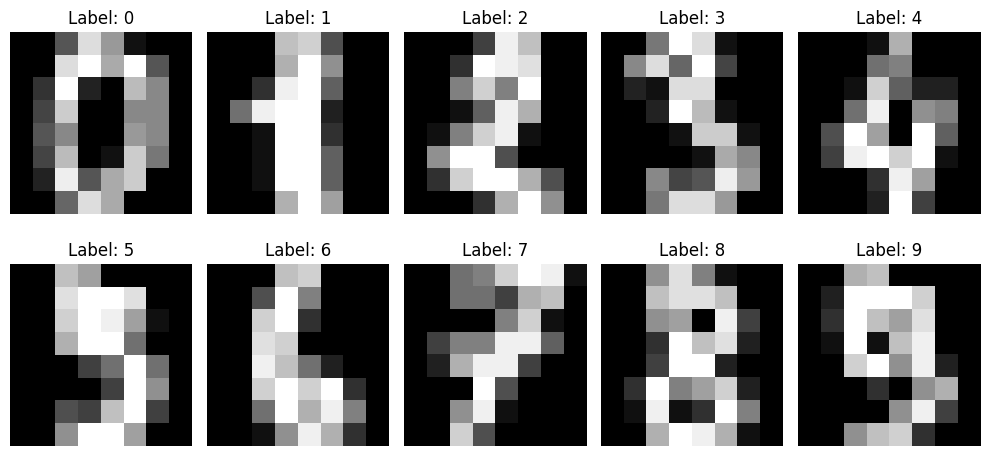

In [56]:
# Load the digits dataset
digits = load_digits()

# Plot the first 10 images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.ravel()

for i in range(10):
    axes[i].imshow(digits.images[i], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Label: {digits.target[i]}")

plt.tight_layout()
plt.show()

## **Data Preprocessing**

In [57]:
# Preprocess the dataset
scaler = MinMaxScaler()
X = scaler.fit_transform(digits.data)
y = digits.target

# One-hot encode the target output
encoder = OneHotEncoder(sparse=False)
y_onehot = encoder.fit_transform(y.reshape(-1, 1))

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

# Split the training set into a smaller training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## **Create Neural Network**

In [81]:
# Create an instance of the NeuralNetwork class
input_size = X.shape[1]
output_size = len(np.unique(y))
loss_func = 'categorical_crossentropy'
init_method = 'glorot_uniform'
epochs = 10000
learning_rate = 0.1
early_stopping = False
patience = 200
dropout_rate = 0.1

# Create the NN
nn = NeuralNetwork([input_size, 64, 64, output_size], loss_func=loss_func, init_method=init_method, dropout_rate=dropout_rate)

# Print the neural network artchitecture
print(nn)

NN Layout:
Input Layer: 64 neuronss
Hidden Layer 1: 64 neuronss
Hidden Layer 2: 64 neurons


## **Train NN**

In [82]:
trainer = Trainer(nn, loss_func)
trainer.train(X_train, y_train, X_val, y_val, epochs=epochs, learning_rate=learning_rate, early_stopping=early_stopping, patience=patience)

# Convert y_test from one-hot encoding to labels
y_test_labels = np.argmax(y_test, axis=1)

# Evaluate the performance of the neural network
predictions = np.argmax(nn.forward(X_test), axis=1)
accuracy = np.mean(predictions == y_test_labels)
print(f"Accuracy: {accuracy:.2%}")

INFO:__main__:Epoch 0: loss = 0.084, val_loss = 0.111
INFO:__main__:Epoch 50: loss = 0.229, val_loss = 0.231
INFO:__main__:Epoch 100: loss = 0.229, val_loss = 0.231
INFO:__main__:Epoch 150: loss = 0.228, val_loss = 0.228
INFO:__main__:Epoch 200: loss = 0.228, val_loss = 0.229
INFO:__main__:Epoch 250: loss = 0.227, val_loss = 0.225
INFO:__main__:Epoch 300: loss = 0.226, val_loss = 0.226
INFO:__main__:Epoch 350: loss = 0.224, val_loss = 0.225
INFO:__main__:Epoch 400: loss = 0.221, val_loss = 0.224
INFO:__main__:Epoch 450: loss = 0.219, val_loss = 0.220
INFO:__main__:Epoch 500: loss = 0.216, val_loss = 0.219
INFO:__main__:Epoch 550: loss = 0.213, val_loss = 0.215
INFO:__main__:Epoch 600: loss = 0.206, val_loss = 0.210
INFO:__main__:Epoch 650: loss = 0.201, val_loss = 0.205
INFO:__main__:Epoch 700: loss = 0.195, val_loss = 0.195
INFO:__main__:Epoch 750: loss = 0.186, val_loss = 0.189
INFO:__main__:Epoch 800: loss = 0.177, val_loss = 0.184
INFO:__main__:Epoch 850: loss = 0.167, val_loss = 0

Accuracy: 96.11%


## **Plot Loss**

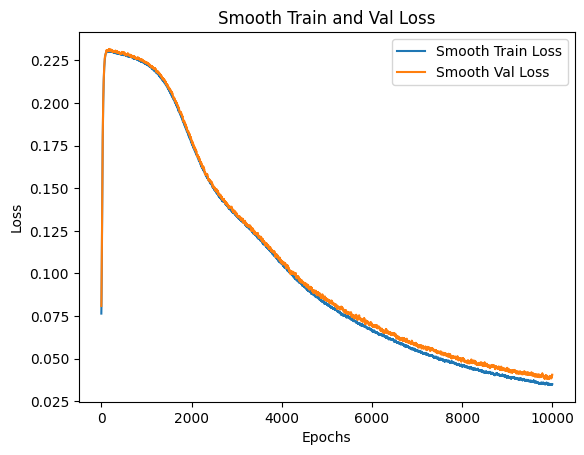

In [78]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_train_loss = smooth_curve(trainer.train_loss)
smooth_val_loss = smooth_curve(trainer.val_loss)

plt.plot(smooth_train_loss, label='Smooth Train Loss')
plt.plot(smooth_val_loss, label='Smooth Val Loss')
plt.title('Smooth Train and Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## **Fine-Tune NN**

In [ ]:
def objective(trial):
    # Define hyperparameters
    n_layers = trial.suggest_int('n_layers', 1, 10)
    # n_layers=1
    hidden_sizes = [trial.suggest_int(f'hidden_size_{i}', 32, 128) for i in range(n_layers)]
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)  # single dropout rate for all layers
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1e-1)
    # epochs = trial.suggest_int('epochs', 500, 10000)
    epochs = 10000
    init_method = trial.suggest_categorical('init_method', ['glorot_uniform', 'glorot_normal', 'he_uniform', 'he_normal', 'random'])
    clip_type = trial.suggest_categorical('clip_type', ['value', 'norm'])
    clip_value = trial.suggest_uniform('clip_value', 0.0, 1.0)

    layers = [input_size] + hidden_sizes + [output_size]
    # Create and train the neural network
    nn = NeuralNetwork(layers=layers, loss_func=loss_func, dropout_rate=dropout_rate, init_method=init_method, clip_type=clip_type, grad_clip=clip_value)
    trainer = Trainer(nn, loss_func)
    trainer.train(X_train, y_train, X_test, y_test, epochs, learning_rate, early_stopping=False)

    # Evaluate the performance of the neural network
    predictions = np.argmax(nn.forward(X_test), axis=1)
    accuracy = np.mean(predictions == y_test_labels)

    return accuracy

# Create a study object and optimize the objective function
study = optuna.create_study(study_name='nn_study', direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best hyperparameters
print(f"Best trial: {study.best_trial.params}")
print(f"Best value: {study.best_trial.value:.3f}")

## **Predict**

In [91]:
best_trial = {'n_layers': 1, 'hidden_size_0': 33, 'dropout_rate': 0.001524880086886879, 'learning_rate': 0.09916060658342357, 'init_method': 'glorot_normal', 'clip_type': 'norm', 'clip_value': 0.9478771616277659}
best_value = 0.978

In [92]:
epochs = 20000
best_nn = NeuralNetwork(layers=[input_size, study.best_trial.params['hidden_size_0'], output_size], 
                        init_method=study.best_trial.params['init_method'],
                        loss_func=loss_func,
                        dropout_rate=study.best_trial.params['dropout_rate'],
                        clip_type=study.best_trial.params['clip_type'],
                        grad_clip=study.best_trial.params['clip_value'])
best_trainer = Trainer(best_nn, loss_func)
best_trainer.train(X_train, y_train, X_test, y_test, epochs, study.best_trial.params['learning_rate'], early_stopping=False)

# Evaluate the performance of the best neural network
predictions = np.argmax(best_nn.forward(X_test), axis=1)
accuracy = np.mean(predictions == y_test_labels)
print(f"Best accuracy: {accuracy:.2%}")

INFO:__main__:Epoch 0: loss = 0.083, val_loss = 0.093
INFO:__main__:Epoch 50: loss = 0.221, val_loss = 0.221
INFO:__main__:Epoch 100: loss = 0.211, val_loss = 0.211
INFO:__main__:Epoch 150: loss = 0.199, val_loss = 0.199
INFO:__main__:Epoch 200: loss = 0.184, val_loss = 0.184
INFO:__main__:Epoch 250: loss = 0.167, val_loss = 0.167
INFO:__main__:Epoch 300: loss = 0.150, val_loss = 0.151
INFO:__main__:Epoch 350: loss = 0.135, val_loss = 0.135
INFO:__main__:Epoch 400: loss = 0.121, val_loss = 0.122
INFO:__main__:Epoch 450: loss = 0.110, val_loss = 0.110
INFO:__main__:Epoch 500: loss = 0.100, val_loss = 0.100
INFO:__main__:Epoch 550: loss = 0.092, val_loss = 0.092
INFO:__main__:Epoch 600: loss = 0.086, val_loss = 0.085
INFO:__main__:Epoch 650: loss = 0.080, val_loss = 0.079
INFO:__main__:Epoch 700: loss = 0.075, val_loss = 0.074
INFO:__main__:Epoch 750: loss = 0.070, val_loss = 0.070
INFO:__main__:Epoch 800: loss = 0.067, val_loss = 0.066
INFO:__main__:Epoch 850: loss = 0.063, val_loss = 0

Best accuracy: 97.78%


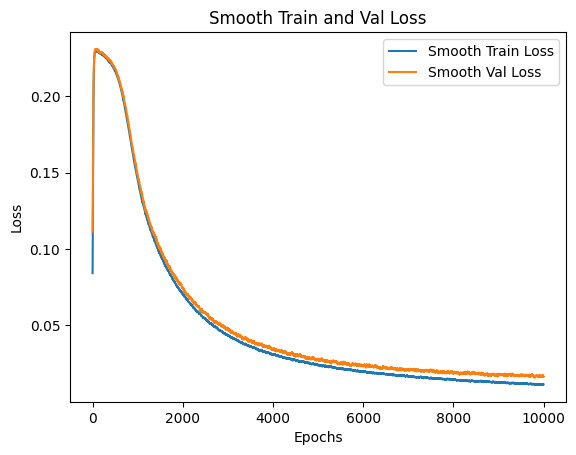

In [93]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_train_loss = smooth_curve(trainer.train_loss)
smooth_val_loss = smooth_curve(trainer.val_loss)

plt.plot(smooth_train_loss, label='Smooth Train Loss')
plt.plot(smooth_val_loss, label='Smooth Val Loss')
plt.title('Smooth Train and Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()